In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import os
from statsmodels.tsa.seasonal import seasonal_decompose
# import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import interpolate
for dirname,_,filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

data/roh/test.csv
data/roh/test_proc_mt.csv
data/roh/submission.csv
data/roh/train.csv
data/roh/solution_example.csv
data/roh/test_calendar.csv
data/roh/train_calendar.csv
data/roh/encoders/onehot_scaler_Brno_1.joblib
data/roh/encoders/onehot_scaler_Prague_3.joblib
data/roh/encoders/x_scaler_Prague_2.joblib
data/roh/encoders/y_scaler_Munich_1.joblib
data/roh/encoders/y_scaler_Prague_2.joblib
data/roh/encoders/y_scaler_Frankfurt_1.joblib
data/roh/encoders/x_scaler_Budapest_1.joblib
data/roh/encoders/y_scaler_Budapest_1.joblib
data/roh/encoders/onehot_scaler_Munich_1.joblib
data/roh/encoders/y_scaler_Brno_1.joblib
data/roh/encoders/onehot_scaler_Budapest_1.joblib
data/roh/encoders/x_scaler_Munich_1.joblib
data/roh/encoders/x_scaler_Brno_1.joblib
data/roh/encoders/y_scaler_Prague_1.joblib
data/roh/encoders/x_scaler_Prague_1.joblib
data/roh/encoders/scaler_config_mt.joblib
data/roh/encoders/x_scaler_Prague_3.joblib
data/roh/encoders/onehot_scaler_Prague_2.joblib
data/roh/encoders/y_scaler_

In [2]:
train = pd.read_csv('data/roh/train.csv')
test = pd.read_csv('data/roh/test.csv')

train_calender = pd.read_csv('data/roh/train_calendar.csv')
test_calender = pd.read_csv('data/roh/test_calendar.csv')

### eda

In [15]:
# train['warehouse'].unique()
train.columns


Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id'],
      dtype='object')

In [5]:
def get_warehouse_info(df,df_test):
    for i,group in df.groupby('warehouse'):
        print(f"===============Warehouse : {i}===============")
        display(group.head(3))
        print("------------------------------------------------------")
        print('len:',group.shape)
        group['date'] = pd.to_datetime(group['date'])
        print("------------------------------------------------------")
        print(group['date'].min(),group['date'].max())
        print("for test ------------------------------------------------------")
        df_test_ = df_test[df_test['warehouse'] == i]
        df_test_['date'] = pd.to_datetime(df_test_['date'])
        print(df_test_['date'].min(),df_test_['date'].max())

In [6]:
get_warehouse_info(train,test)

===============Warehouse : Brno_1===============


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
1193,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,2332.0,27392.0,Brno_1_2020-12-05
1194,Brno_1,2020-12-06,5338.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,2294.0,27305.0,Brno_1_2020-12-06
1195,Brno_1,2020-12-07,5621.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,2305.0,27255.0,Brno_1_2020-12-07


------------------------------------------------------
len: (1193, 18)
------------------------------------------------------
2020-12-05 00:00:00 2024-03-15 00:00:00
for test ------------------------------------------------------
2024-03-16 00:00:00 2024-05-15 00:00:00
===============Warehouse : Budapest_1===============


/tmp/ipykernel_305544/3846750154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['date'] = pd.to_datetime(df_test_['date'])


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
6186,Budapest_1,2020-12-05,4623.0,NaN,0,0,0,0,0,0,0,0.0,0,0.3,0.0,3046.0,17840.0,Budapest_1_2020-12-05
6187,Budapest_1,2020-12-06,4197.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,3016.0,17808.0,Budapest_1_2020-12-06
6188,Budapest_1,2020-12-07,4452.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,3047.0,17813.0,Budapest_1_2020-12-07


------------------------------------------------------
len: (1154, 18)
------------------------------------------------------
2020-12-05 00:00:00 2024-03-14 00:00:00
for test ------------------------------------------------------
2024-03-16 00:00:00 2024-05-15 00:00:00
===============Warehouse : Frankfurt_1===============


/tmp/ipykernel_305544/3846750154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['date'] = pd.to_datetime(df_test_['date'])


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
5557,Frankfurt_1,2022-02-18,929.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,899.0,2691.0,Frankfurt_1_2022-02-18
5558,Frankfurt_1,2022-02-19,931.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,900.0,2747.0,Frankfurt_1_2022-02-19
5559,Frankfurt_1,2022-02-23,945.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,897.0,2885.0,Frankfurt_1_2022-02-23


------------------------------------------------------
len: (629, 18)
------------------------------------------------------
2022-02-18 00:00:00 2024-03-15 00:00:00
for test ------------------------------------------------------
2024-03-16 00:00:00 2024-05-15 00:00:00
===============Warehouse : Munich_1===============


/tmp/ipykernel_305544/3846750154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['date'] = pd.to_datetime(df_test_['date'])


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
4772,Munich_1,2021-07-21,1139.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,910.0,1797.0,Munich_1_2021-07-21
4773,Munich_1,2021-07-29,890.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,552.0,2042.0,Munich_1_2021-07-29
4774,Munich_1,2021-08-06,797.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,667.0,2380.0,Munich_1_2021-08-06


------------------------------------------------------
len: (785, 18)
------------------------------------------------------
2021-07-21 00:00:00 2024-03-15 00:00:00
for test ------------------------------------------------------
2024-03-16 00:00:00 2024-05-15 00:00:00
===============Warehouse : Prague_1===============


/tmp/ipykernel_305544/3846750154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['date'] = pd.to_datetime(df_test_['date'])


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07


------------------------------------------------------
len: (1193, 18)
------------------------------------------------------
2020-12-05 00:00:00 2024-03-15 00:00:00
for test ------------------------------------------------------
2024-03-16 00:00:00 2024-05-15 00:00:00
===============Warehouse : Prague_2===============


/tmp/ipykernel_305544/3846750154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['date'] = pd.to_datetime(df_test_['date'])


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
2386,Prague_2,2020-12-05,4154.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1317.0,18462.0,Prague_2_2020-12-05
2387,Prague_2,2020-12-06,4016.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1306.0,18401.0,Prague_2_2020-12-06
2388,Prague_2,2020-12-07,3917.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1313.0,18380.0,Prague_2_2020-12-07


------------------------------------------------------
len: (1193, 18)
------------------------------------------------------
2020-12-05 00:00:00 2024-03-15 00:00:00
for test ------------------------------------------------------
2024-03-16 00:00:00 2024-05-15 00:00:00
===============Warehouse : Prague_3===============


/tmp/ipykernel_305544/3846750154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['date'] = pd.to_datetime(df_test_['date'])


,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
3579,Prague_3,2020-12-05,4091.0,NaN,0,0,0,0,0,0,0,0.0,0,NaN,NaN,964.0,17693.0,Prague_3_2020-12-05
3580,Prague_3,2020-12-06,3972.0,NaN,0,0,0,0,0,0,0,0.0,0,NaN,NaN,965.0,17675.0,Prague_3_2020-12-06
3581,Prague_3,2020-12-07,3903.0,NaN,0,0,0,0,0,0,0,0.0,0,NaN,NaN,969.0,17660.0,Prague_3_2020-12-07


------------------------------------------------------
len: (1193, 18)
------------------------------------------------------
2020-12-05 00:00:00 2024-03-15 00:00:00
for test ------------------------------------------------------
2024-03-16 00:00:00 2024-05-15 00:00:00


/tmp/ipykernel_305544/3846750154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_['date'] = pd.to_datetime(df_test_['date'])


In [4]:
(pd.concat([(train[train['warehouse'] == 'Frankfurt_1']), (test[test['warehouse'] == 'Frankfurt_1'])], axis=0)['orders'].shift(60)).to_csv('test_data_fields.csv')

In [149]:
test_x = train[train['warehouse'] == 'Frankfurt_1'][['orders','date']].reset_index(drop=True)
test_x['date'] = pd.to_datetime(test_x['date'])
test_x.index = test_x['date']
test_x.drop(columns=['date'],inplace = True)
# display(test_x)
# stl = STL(test_x, seasonal=6,)  # 13 is typically used for monthly data with weekly seasonality
# result = stl.fit()

# Extracting the components
# train['trend'] = result.trend
# train['seasonal'] = result.seasonal
# train['residual'] = result.resid

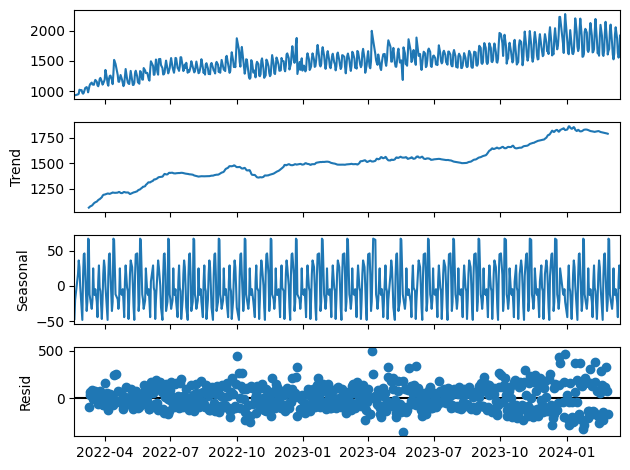

In [156]:

decomposed = seasonal_decompose(test_x, model='additive', filt=None, period=30, two_sided=True, extrapolate_trend=0)
_ = decomposed.plot()

In [42]:
decomposed.seasonal.values.shape

(629,)

In [40]:
# list[decomposed.seasonal[:13].values]*len(test_x)//13

In [31]:
# decomposed.plot()

### Processing

In [73]:
## constants:

WAREHOUSE = ['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1',
       'Frankfurt_1', 'Budapest_1']

LAG_DAYS = [63,90,150,364]
ROLLING_WINDOW = [63,90,150,364]
SEASONAL_COMPS = [7,14,30]



In [74]:
def merge_on_common_columns(train_df,calender_df):
    common_columns = set(train_df.columns).intersection(set(calender_df.columns))
    print(common_columns)

    return pd.merge(train_df,calender_df,on=list(common_columns))
train_df_merged = merge_on_common_columns(train,train_calender)
test_df_merged = merge_on_common_columns(test,test_calender)
train_df = train_df_merged.sort_values(by=['date','warehouse'])
test_df = test_df_merged.sort_values(by=['date','warehouse'])

{'date', 'blackout', 'precipitation', 'frankfurt_shutdown', 'mov_change', 'shutdown', 'mini_shutdown', 'winter_school_holidays', 'holiday_name', 'snow', 'warehouse', 'shops_closed', 'school_holidays', 'holiday'}
{'date', 'winter_school_holidays', 'holiday_name', 'warehouse', 'shops_closed', 'school_holidays', 'holiday'}


In [75]:
## remove uncommon columns from train not in test:
unavailable_columns = list(set(train_df.columns).difference(set(test_df.columns)))
unavailable_columns.remove('orders')
train_df.drop(columns=unavailable_columns,inplace=True)

In [76]:
## merging train , test for features:
train_df = pd.concat([train_df, test_df], axis=0)

train_df = train_df.drop(columns=['holiday_name'])

train_df = train_df.sort_values(by=['date', 'warehouse'], ignore_index=True)

train_df.head(2)

,warehouse,date,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Brno_1,2020-12-05,6447.0,0,0,0,0,Brno_1_2020-12-05
1,Budapest_1,2020-12-05,4623.0,0,0,0,0,Budapest_1_2020-12-05


In [77]:
from math import pi
def process_date(df):
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract date-related features
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    #df['day_of_year'] = df['date'].dt.dayofyear
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    
    # Calculate days since the start date
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    
    # Create cyclic features
    def cyclical_encode(df, col, max_val):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    
    cyclical_encode(df, 'month', 12)
    #cyclical_encode(df, 'day_of_week', 7)
    #cyclical_encode(df, 'day_of_year', 365)
    #cyclical_encode(df, 'day', 30)4


    # Create seasonal features

    


    categorical_features = ['day_of_week', 'month', 'quarter', 'day', "year"]
    binary_features = ['is_weekend']
    return df, categorical_features, binary_features

In [78]:
def create_lag_features(df, col, lag_days):
    df = df.copy()
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df[col].rolling(window, min_periods=1).mean()
        df[std_feature] = df[col].rolling(window, min_periods=1).std()
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

def seasonal_component(df,col,periods):
        df_ = df[~df['orders'].isna()].copy()
        df_['date'] = pd.to_datetime(df_['date'])
        df_.index = df_['date']
        df_.drop(columns=['date'],inplace = True)
        # display(df_.head(3))
        seasonal_features = []
        for period in periods:
            decomposed = seasonal_decompose(df_[col], model='additive', filt=None, period=period, two_sided=True, extrapolate_trend=0)
            additional_vals = np.tile(decomposed.seasonal.values[:period],len(df[df['orders'].isna()]) )[:len(df[df['orders'].isna()])]
            df[f'{col}_seasonal_{period}'] = np.concatenate((decomposed.seasonal.values,additional_vals))
            seasonal_features.append(f'{col}_seasonal_{period}')
        return df,seasonal_features


In [79]:
train_df, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders', 'id', 'date'})
print(x_scaler_features)
print(categorical_features)
print(binary_features)

['month_cos', 'days_since_start', 'month_sin']
['day_of_week', 'month', 'quarter', 'day', 'year']
['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']


In [80]:
train_df.shape,train_df.columns,

((7737, 17),
 Index(['warehouse', 'date', 'orders', 'holiday', 'shops_closed',
        'winter_school_holidays', 'school_holidays', 'id', 'quarter', 'year',
        'month', 'day', 'day_of_week', 'is_weekend', 'days_since_start',
        'month_sin', 'month_cos'],
       dtype='object'))

In [81]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, redundant_features=[], inference=False, fill_method='ffill'):
    warehouse = df['warehouse'].iloc[0]
    redundant_df = df[redundant_features]
    date_df = df['date']
    df = df.drop(columns=redundant_features)
    
    if not inference:
        # Create lag and rolling features
        df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)
        df,seasonal_features = seasonal_component(df,'orders',SEASONAL_COMPS)
        x_scaler_features = x_scaler_features + lag_features + window_features + seasonal_features
        
        # Handle NaN values in lag and rolling features
        if fill_method == 'ffill':
            df[lag_features + window_features] = df[lag_features + window_features].ffill().bfill()
            orders = df["orders"]
            df = df.ffill().bfill()
            df["orders"] = orders
            
        elif fill_method == 'zero':
            df[lag_features + window_features] = df[lag_features + window_features].fillna(0)
            orders = df["orders"]
            df = df.fillna(0)
            df["orders"] = orders
    # print(df.columns)
    # One-hot encoding for categorical features
    if not inference:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, f'/home/smart/sanket/experiments/data/roh/encoders/onehot_scaler_{warehouse}.joblib')
    else:
        encoder = joblib.load(f'/home/smart/sanket/experiments/data/roh/encoders/onehot_scaler_{warehouse}.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)
    # print(df.columns)
    # Prepare features for scaling
    X = df.drop(columns=['orders'])
    y = df['orders']

    # Initialize and fit/transform scalers
    if not inference:
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_scaled = x_scaler.fit_transform(X[x_scaler_features])
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        joblib.dump(x_scaler, f'/home/smart/sanket/experiments/data/roh/encoders/x_scaler_{warehouse}.joblib')
        joblib.dump(y_scaler, f'/home/smart/sanket/experiments/data/roh/encoders/y_scaler_{warehouse}.joblib')
    else:
        x_scaler = joblib.load(f'/home/smart/sanket/experiments/data/roh/encoders/x_scaler_{warehouse}.joblib')
        X_scaled = x_scaler.transform(X[x_scaler_features])
        y_scaler = joblib.load(f'/home/smart/sanket/experiments/data/roh/encoders/y_scaler_{warehouse}.joblib')
        y_scaled = y_scaler.transform(y.values.reshape(-1, 1))

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)
    # print(X_scaled_df.columns)
    # Combine all features
    final_df = pd.concat([
        X_scaled_df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        df[binary_features],  # Binary features (unchanged)
        redundant_df,  # Add redundant features back for the test data export
        date_df
    ], axis=1)
    print(final_df.shape, y_scaled.shape)
    return final_df, y_scaled

In [82]:
features = [f'orders_lag_{lag}' for lag in LAG_DAYS]
features2 = [f'orders_rolling_mean_{window}' for window in ROLLING_WINDOW]

# Get unique warehouses
warehouses = train_df['warehouse'].unique()

# Create separate dataframes for each warehouse
warehouse_dfs = {wh: train_df[train_df['warehouse'] == wh].copy() for wh in warehouses}

# Preprocess each warehouse dataframe
processed_train_data_dict = {}
processed_test_data = []

for warehouse, df in warehouse_dfs.items():
    print(f"Processing warehouse: {warehouse}")
    
    # Sort dataframe by date ascendentaly
    df = df.sort_values(by=['date'])

    # Get indices of NaN values in 'orders' column
    nan_indices = df[df['orders'].isna()].index

    # Plot outlier comparison if needed
    # df = plot_outlier_comparison(df, window=70, z_threshold=2.5, weight=0.5)

    # Preprocess data
    X_processed, y_processed = preprocess_data(df, 
                                               categorical_features, 
                                               x_scaler_features, 
                                               binary_features, 
                                               redundant_features=['warehouse', 'id'], 
                                               inference=False, 
                                               fill_method='none')
    

    
    # Get test data using NaN indices
    test_data = X_processed.loc[nan_indices]
    
    # Convert index to integer positions for np.delete
    nan_positions = X_processed.index.get_indexer(nan_indices)
    
    # Drop NaN indices from processed data
    X_processed = X_processed.drop(nan_indices)
    y_processed = np.delete(y_processed, nan_positions)
    
    processed_test_data.append(test_data)
    processed_train_data_dict[warehouse] = (X_processed, y_processed)
    
    print(f"Processed:\ntrain data shape: {X_processed.shape}, {y_processed.shape}")
    print("test data shape:", test_data.shape)
    print(f"y nans: {sum(np.isnan(y_processed))}")
    print("\n")
    
# Combine all test data rows into a single DataFrame
processed_test_df = pd.concat(processed_test_data)

Processing warehouse: Brno_1
(1254, 85) (1254, 1)
Processed:
train data shape: (1193, 85), (1193,)
test data shape: (61, 85)
y nans: 0


Processing warehouse: Budapest_1
(1211, 85) (1211, 1)
Processed:
train data shape: (1154, 85), (1154,)
test data shape: (57, 85)
y nans: 0


Processing warehouse: Prague_1
(1254, 85) (1254, 1)
Processed:
train data shape: (1193, 85), (1193,)
test data shape: (61, 85)
y nans: 0


Processing warehouse: Prague_2
(1254, 85) (1254, 1)
Processed:
train data shape: (1193, 85), (1193,)
test data shape: (61, 85)
y nans: 0


Processing warehouse: Prague_3
(1254, 85) (1254, 1)
Processed:
train data shape: (1193, 85), (1193,)
test data shape: (61, 85)
y nans: 0


Processing warehouse: Munich_1
(833, 84) (833, 1)
Processed:
train data shape: (785, 84), (785,)
test data shape: (48, 84)
y nans: 0


Processing warehouse: Frankfurt_1
(677, 82) (677, 1)
Processed:
train data shape: (629, 82), (629,)
test data shape: (48, 82)
y nans: 0




In [83]:
# Save the test dataset for future use
processed_test_df.to_csv('data/roh/test_proc_mt.csv')

In [84]:
for warehouse, (X_processed, y_processed) in processed_train_data_dict.items():
    print(f"Warehouse: {warehouse}")
    print("Start Date:", X_processed["date"].min())
    print("End Date:", X_processed["date"].max())
    print()

Warehouse: Brno_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Budapest_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-14 00:00:00

Warehouse: Prague_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_2
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_3
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Munich_1
Start Date: 2021-07-21 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Frankfurt_1
Start Date: 2022-02-18 00:00:00
End Date: 2024-03-15 00:00:00



In [85]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled,
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

def create_sequences2(data, target, time_steps, mode='causal'):
    sequences = []
    y_sequences = []
    
    for i in range(len(data)):
        seq = data.iloc[max(0, i-time_steps+1):i+1].values
        if len(seq) < time_steps:
            if mode == 'causal':
                padding = np.tile(seq[0], (time_steps - len(seq), 1))
            else:
                padding = np.zeros((time_steps - len(seq), seq.shape[1]))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
        
        # Collect the corresponding target value
        y_sequences.append(target[i])
    
    return np.array(sequences), np.array(y_sequences)

# Example usage
# X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, 63)


In [86]:
FILL = True

#print nan values for every warehouse in train dataset dict:
for warehouse in processed_train_data_dict.keys():
    print(f"Nan X values for {warehouse}: {processed_train_data_dict[warehouse][0].isna().sum().sum()}")
    print(f"nan y values for {warehouse}: {sum(np.isnan(processed_train_data_dict[warehouse][1]))}")
    
    if FILL:
        feat, targ = processed_train_data_dict[warehouse]

        feat = feat.fillna(0)
        targ = np.nan_to_num(targ, nan=0.0)
        processed_train_data_dict[warehouse] = (feat, targ)

if FILL:
    print("\n After FILL:")
    for warehouse in processed_train_data_dict.keys():
        print(f"Nan X values for {warehouse}: {processed_train_data_dict[warehouse][0].isna().sum().sum()}")
        print(f"nan y values for {warehouse}: {sum(np.isnan(processed_train_data_dict[warehouse][1]))}")

Nan X values for Brno_1: 671
nan y values for Brno_1: 0
Nan X values for Budapest_1: 671
nan y values for Budapest_1: 0
Nan X values for Prague_1: 671
nan y values for Prague_1: 0
Nan X values for Prague_2: 671
nan y values for Prague_2: 0
Nan X values for Prague_3: 671
nan y values for Prague_3: 0
Nan X values for Munich_1: 671
nan y values for Munich_1: 0
Nan X values for Frankfurt_1: 671
nan y values for Frankfurt_1: 0

 After FILL:
Nan X values for Brno_1: 0
nan y values for Brno_1: 0
Nan X values for Budapest_1: 0
nan y values for Budapest_1: 0
Nan X values for Prague_1: 0
nan y values for Prague_1: 0
Nan X values for Prague_2: 0
nan y values for Prague_2: 0
Nan X values for Prague_3: 0
nan y values for Prague_3: 0
Nan X values for Munich_1: 0
nan y values for Munich_1: 0
Nan X values for Frankfurt_1: 0
nan y values for Frankfurt_1: 0


### Model

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class TimeSeriesModel(nn.Module):
#     def __init__(self, input_shape, lr=1e-3):
#         super(TimeSeriesModel, self).__init__()
        
#         self.lstm = nn.LSTM(input_shape[2], 32, bidirectional=True, batch_first=True)
#         self.fc1 = nn.Linear(32 * 2, 32)  # 32 * 2 because of bidirectional LSTM
#         self.fc2 = nn.Linear(32, 16)
#         self.fc3 = nn.Linear(16, 1)
#         self.dropout = nn.Dropout(0.2)
#         self.relu = nn.ReLU()

#         self.optimizer = optim.Adam(self.parameters(), lr=lr)
#         self.criterion = nn.MSELoss()
    
#     def forward(self, x):
#         h0 = torch.zeros(2, x.size(0), 32).to(x.device)  # 2 for bidirectional
#         c0 = torch.zeros(2, x.size(0), 32).to(x.device)
        
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.dropout(self.relu(self.fc1(out[:, -1, :])))
#         out = self.dropout(self.relu(self.fc2(out)))
#         out = self.fc3(out)
#         return out
# class TimeSeriesModel(nn.Module):
#     def __init__(self, input_shape, lr=1e-3):
#         super(TimeSeriesModel, self).__init__()
        
#         self.lstm = nn.LSTM(input_shape[2], 32, bidirectional=True, batch_first=True)
#         self.fc1 = nn.Linear(32 * 2, 64)  # Increased size for first FC layer
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
#         self.fc4 = nn.Linear(16, 1)
#         self.dropout = nn.Dropout(0.2)
#         self.relu = nn.ReLU()

#         self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
#         self.criterion = nn.MSELoss()
    
#     def forward(self, x):
#         h0 = torch.zeros(2, x.size(0), 32).to(x.device)
#         c0 = torch.zeros(2, x.size(0), 32).to(x.device)
        
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.dropout(self.relu(self.fc1(out[:, -1, :])))
#         out = self.dropout(self.relu(self.fc2(out)))
#         out = self.dropout(self.relu(self.fc3(out)))
#         out = self.fc4(out)
#         return out
class TimeSeriesModel(nn.Module):
    def __init__(self, input_shape, lr=1e-3):
        super(TimeSeriesModel, self).__init__()
        
        self.lstm = nn.LSTM(input_shape[2], 32, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(32 * 2, 32)
        self.fc2 = nn.Linear(32, 32)  # Matching output dimension for residual connection
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
    
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32).to(x.device)
        c0 = torch.zeros(2, x.size(0), 32).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(self.fc1(out[:, -1, :]))
        residual = out  # Save for residual connection
        out = self.dropout(self.relu(self.fc2(out)))
        out += residual  # Add residual connection
        out = self.dropout(self.relu(self.fc3(out)))
        out = self.fc4(out)
        return out

def create_model(input_shape, lr=1e-3):
    model = TimeSeriesModel(input_shape, lr)
    return model


In [88]:
# Sample input
batch_size = 32
seq_len = 63  # Length of the time series sequence
input_size = 77  # Number of input features
d_model = 64 
nhead = 4
num_encoder_layers = 3  # Number of transformer encoder layers
dim_feedforward = 256  # Dimension of the feedforward network
dropout = 0.1  # Dropout rate
max_len = 5000  # Maximum length of the time series
# Create random input data
x = torch.rand(batch_size, seq_len, input_size)
TIME_STEPS = 63
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# Create model and forward pass
model = create_model(x.shape, lr=1e-3)#TimeSeriesTransformer(input_size, d_model, nhead, num_encoder_layers, dim_feedforward, dropout, max_len)
output = model(x)
print(output.shape) 

torch.Size([32, 1])


In [89]:
# model

In [90]:
import matplotlib.pyplot as plt
def plot_loss(train_losses, val_losses, warehouse):
    plt.figure(figsize=(6, 4))
    
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
    
    min_val_loss = min(val_losses)
    min_val_loss_epoch = val_losses.index(min_val_loss)
    plt.axvline(min_val_loss_epoch, linestyle='--', color='gray', linewidth=1)
    plt.text(min_val_loss_epoch, min_val_loss, f'Min Val Loss: {min_val_loss:.4f}', 
             verticalalignment='bottom', horizontalalignment='right', color='gray', fontsize=10)
    
    plt.title(f'Training and Validation Loss for Warehouse: {warehouse}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.savefig(f'/home/smart/sanket/experiments/data/roh/models_warehouse/training_validation_loss_{warehouse}.png', dpi=300)
    plt.show()

In [91]:
def train_transformer(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        if (epoch+1)%100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

Training model for warehouse: Brno_1
(1073, 63, 82)
Epoch 100/300, Train Loss: 0.1674, Val Loss: 0.2268
Epoch 200/300, Train Loss: 0.1194, Val Loss: 0.1813
Epoch 300/300, Train Loss: 0.1102, Val Loss: 0.1802


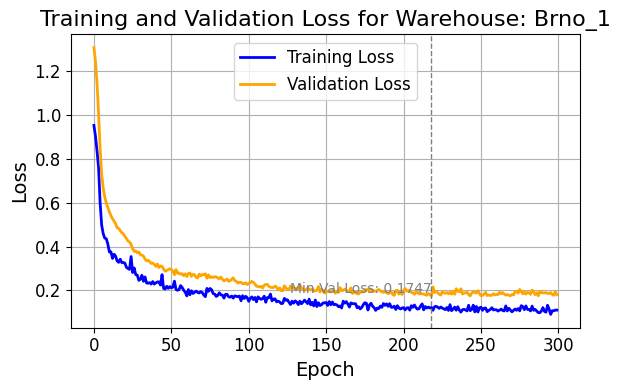

Training model for warehouse: Budapest_1
(1038, 63, 82)
Epoch 100/300, Train Loss: 0.1394, Val Loss: 0.1014
Epoch 200/300, Train Loss: 0.1231, Val Loss: 0.0876
Epoch 300/300, Train Loss: 0.1117, Val Loss: 0.0848


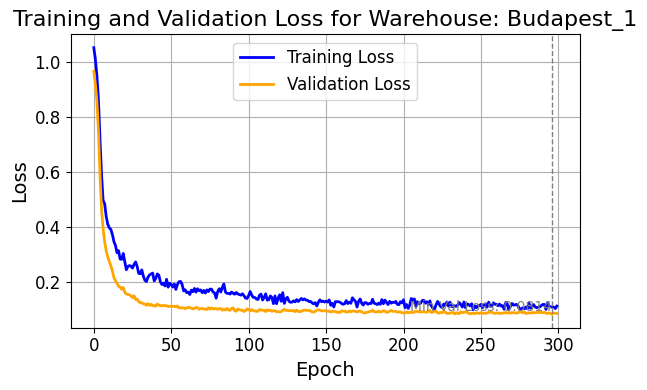

Training model for warehouse: Prague_1
(1073, 63, 82)
Epoch 100/300, Train Loss: 0.1915, Val Loss: 0.1570
Epoch 200/300, Train Loss: 0.1165, Val Loss: 0.1517


KeyboardInterrupt: 

In [92]:
# Training loop:

val_data = {}
training_features = {}

for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Training model for warehouse: {warehouse}")

    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse', 'date'])
    
    training_features[warehouse] = X_train_scaled.columns.tolist()

    # Create sequences
    X_seq, y_seq = create_sequences2(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)
    
    # train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=True)
    
    # Convert to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Create the model
    input_size = X_train.shape[2]
    print(X_train.shape)
    model = create_model(X_train.shape, lr=1e-3)#TimeSeriesTransformer(input_size=input_size, d_model=64, nhead=4, num_encoder_layers=3, dim_feedforward=256, dropout=0.1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    train_losses, val_losses = train_transformer(model, train_loader, val_loader, criterion, optimizer, EPOCHS)
    
    plot_loss(train_losses, val_losses, warehouse)
    
    # Save the model
    torch.save(model.state_dict(), f'/home/smart/sanket/experiments/data/roh/models_warehouse/model_{warehouse}.pt')
    
    # Save the validation data for future evaluation
    val_data[warehouse] = (X_val, y_val)

### inference

In [28]:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
    'training_features': training_features,
}

joblib.dump(scaler_config, '/home/smart/sanket/experiments/data/roh/encoders/scaler_config_mt.joblib')

['/home/smart/sanket/experiments/data/roh/encoders/scaler_config_mt.joblib']

In [29]:
def create_sequences(data, max_time_steps):

    sequences = []
    for i in range(len(data)):
        seq = data.iloc[max(0, i-max_time_steps+1):i+1].values
        if len(seq) < max_time_steps:
            padding = np.tile(seq[0], (max_time_steps - len(seq), 1))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
    return np.array(sequences)

In [30]:
def predict_multiple(data, time_steps, warehouses_trained, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouses_trained:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue
        model_data = warehouses_trained[warehouse]
        model = model_data['model']
        y_scaler = model_data['y_scaler']
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features[warehouse])
    
        sequences = create_sequences(wh_data, time_steps)


        # Predict on all sequences
        model.eval()
        print(model)
        preds = model(torch.tensor(sequences, dtype=torch.float32))
        preds_rescaled = y_scaler.inverse_transform(preds.detach().numpy())

        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)

        # Calculate the number of predictions
        num_predictions = len(preds_rescaled)

        # Assign predictions, accounting for the offset due to sequence creation
        wh_predictions[-num_predictions:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()

        wh_submission_data['predicted_orders'] = wh_predictions

        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)

    return np.array(predictions), submission_df

In [35]:
def load_models_and_scalers(warehouses):
    warehouse_models_and_scalers = {}

    for wh in warehouses:
        try:
            # model  = torch.load(f'model_{wh}.pt')#tf.keras.models.load_model(f'model_{wh}.keras')
            # print(wh)
            if wh == 'Munich_1':
                model = create_model(input_shape=[2,63,83])
            elif wh == 'Frankfurt_1':
                model = create_model(input_shape=[2,63,81])
            else:
                print(wh)
                model = create_model(input_shape=x.shape)
            # print(f'model_{wh}.pt')
            model.load_state_dict(torch.load(f'/home/smart/sanket/experiments/data/roh/models_warehouse/model_{wh}.pt'))
            x_scaler = joblib.load(f'/home/smart/sanket/experiments/data/roh/encoders/x_scaler_{wh}.joblib')
            
            y_scaler = joblib.load(f'/home/smart/sanket/experiments/data/roh/encoders/y_scaler_{wh}.joblib')
            encoder = joblib.load(f'/home/smart/sanket/experiments/data/roh/encoders/onehot_scaler_{wh}.joblib')
            
            warehouse_models_and_scalers[wh] = {
                'model': model,
                'x_scaler': x_scaler,
                'y_scaler': y_scaler,
                'encoder': encoder
            }
        except Exception as e:
            print(f"Error loading model or scaler for warehouse {wh}: {str(e)}")

    return warehouse_models_and_scalers

In [36]:
scaler_config = joblib.load('/home/smart/sanket/experiments/data/roh/encoders/scaler_config_mt.joblib') # load the scaler config

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']    # training features dictionary
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

cat_features: ['day_of_week', 'month', 'quarter', 'day', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 3


In [37]:
dataframe = pd.read_csv("data/roh/test_proc_mt.csv")
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by=['date', 'warehouse'])
print(f"Rows: {len(dataframe)}")

Rows: 397


In [38]:
x = torch.rand(batch_size, seq_len, 84)
warehouse_models = load_models_and_scalers(warehouses)
predictions, submission_df = predict_multiple(dataframe, TIME_STEPS, warehouse_models, training_features)
len(submission_df.predicted_orders)

Brno_1
Budapest_1
Prague_1
Prague_2
Prague_3
TimeSeriesModel(
  (lstm): LSTM(84, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (criterion): MSELoss()
)
TimeSeriesModel(
  (lstm): LSTM(84, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (criterion): MSELoss()
)
TimeSeriesModel(
  (lstm): LSTM(81, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): 

/tmp/ipykernel_1613373/372337644.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/home/smart/sanket/experiments/data/roh/models_wareh

397

In [39]:
submission_export = submission_df[["id", "predicted_orders"]]

In [40]:

submission_export.to_csv('/home/smart/sanket/experiments/data/roh/submission.csv', index=False)